In [1]:
render = 0

In [2]:
import os
directory = '../../output.tara-delmont'
render='svg'
name=os.path.basename(directory)

In [3]:
if not render: render_name = None
else: render_name = render

In [4]:
from collections import defaultdict
import json
from sourmash.lca import LineagePair, display_lineage
from charcoal.utils import make_lineage, load_contamination_summary
import numpy

import plotly.graph_objects as go

In [5]:
# load contamination summary from given directory!
with open(f'{directory}/contam_summary.json', 'rt') as fp:
    source_d = load_contamination_summary(fp)

In [6]:
# do sorting and maybe some filtering by rank

filter_rank = set()
filter_rank = set(['superkingdom', 'phylum'])

pairtup_list = []
for k, target_d in source_d.items():
    if filter_rank and k[-1].rank not in filter_rank: continue
    for lin, count in target_d.items():
        if filter_rank and lin[-1].rank not in filter_rank: continue
        
        keytup = (k, lin)
        pairtup_list.append((count, keytup))

pairtup_list.sort(reverse=True)

for count, (k, lin) in pairtup_list:
    print(f"{count} - genome {display_lineage(k)} <- contam {display_lineage(lin)}")

2692 - genome d__Eukaryota <- contam d__Bacteria
396 - genome d__Eukaryota <- contam d__Archaea
259 - genome d__Archaea <- contam d__Bacteria
245 - genome d__Bacteria;p__Proteobacteria <- contam d__Bacteria;p__Gemmatimonadota
212 - genome d__Bacteria <- contam d__Archaea
203 - genome d__Bacteria;p__Proteobacteria <- contam d__Bacteria;p__Latescibacterota
194 - genome d__Bacteria;p__Nitrospinota <- contam d__Bacteria;p__Chloroflexota
175 - genome d__Bacteria;p__Proteobacteria <- contam d__Bacteria;p__Bacteroidota
167 - genome d__Bacteria;p__Planctomycetota <- contam d__Bacteria;p__Proteobacteria
160 - genome d__Bacteria;p__Margulisbacteria <- contam d__Bacteria;p__Proteobacteria
147 - genome d__Bacteria;p__Bacteroidota <- contam d__Bacteria;p__Proteobacteria
124 - genome d__Bacteria;p__Verrucomicrobiota <- contam d__Bacteria;p__Myxococcota
118 - genome d__Bacteria;p__Verrucomicrobiota <- contam d__Bacteria;p__Proteobacteria
114 - genome d__Bacteria;p__Proteobacteria <- contam d__Bacteri

In [7]:
## construct 

# subselect list down to 20 items
sub_list = pairtup_list[:20]

class NextIndex:
    def __init__(self):
        self.idx = -1
        
    def __call__(self):
        self.idx += 1
        return self.idx
    
    def __len__(self):
        return self.idx + 1
    
source_idx = NextIndex()
source_indices = defaultdict(source_idx)

target_idx = NextIndex()
target_indices = defaultdict(target_idx)

for count, (source, target) in sub_list:
    _ = source_indices[source]
    _ = target_indices[target]
    
mat = numpy.zeros((len(source_idx), len(target_idx)))

for count, (source, target) in sub_list:
    i = source_indices[source]
    j = target_indices[target]

    mat[i,j] += count
#    print(display_lineage(source), display_lineage(target), count)
    
source_labels = [""] * len(source_idx)
for k, idx in source_indices.items():
    source_labels[idx] = display_lineage(k)
    
target_labels = [""] * len(target_idx)
for k, idx in target_indices.items():
    target_labels[idx] = display_lineage(k)
    
    
mat_l = []
for j in range(len(target_idx)):
    x = []
    for i in range(len(source_idx)):
#        print('XXX', source_labels[i], target_labels[j], mat[i, j])
        x.append(mat[i, j])
    mat_l.append(x)

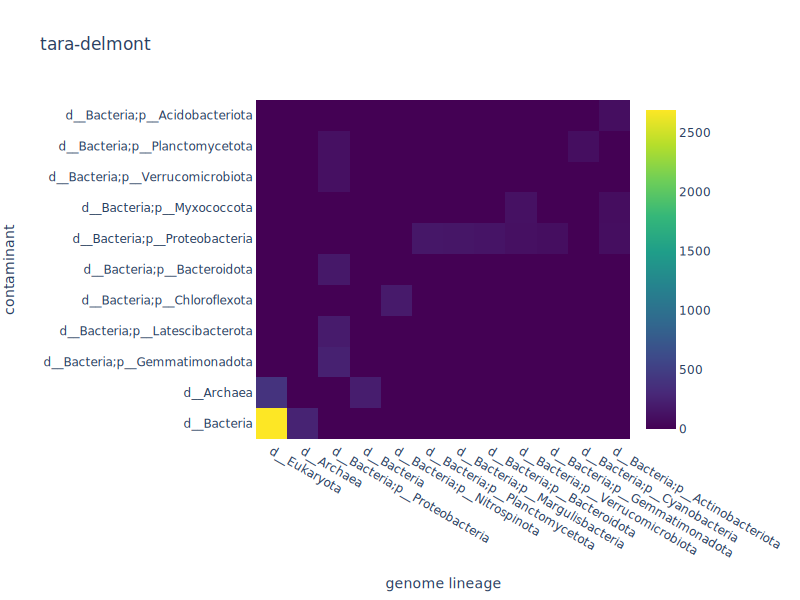

In [8]:
# make actual plot!
fig = go.Figure(data=go.Heatmap(
                   z=mat_l,
                   x=source_labels,
                   y=target_labels,
                   hoverongaps = False,
                   colorscale="Viridis"))
fig.update_layout(xaxis_title='genome lineage', yaxis_title='contaminant',
                  title=f'{name[7:]}')
fig.show(render_name, width=800, height=600)